# Hubbard Model: A Tunable Model of Electron Correlation
**Evangeslista Group Rotation Project**

Brian Zhao, 10 Oct 2022

We first consider the simplest case, an open, one-dimensional Hubbard model. For an $N$-site $1$-D Hubbard model, we represent a configuration as
$$
|\mathbf{\text{n}}\rangle = |\underbrace{k_{1\uparrow}k_{2\uparrow}k_{3\uparrow}\dots k_{N\uparrow}}_{\text{alpha}}\underbrace{k_{1\downarrow}k_{2\downarrow}k_{3\downarrow}\dots k_{N\downarrow}}_{\text{beta}}\rangle
$$
where $k_i$ is the occupatation number of the $i$-th spinorbital.

In [105]:
import numpy as np
import scipy.special
from IPython.display import display, Math
import matplotlib.pyplot as plt
%matplotlib widget

def get_excitation_level(f1, f2):
    """
    Get the excitation level between two bit strings f1 and f2, i.e., half the Hamming distance.
    """
    return int(count_set_bits(f1^f2)/2)    

def count_set_bits(f):
    """
    Return the number of set (1) bits in the bit string f.
    """
    return int(bin(f).count('1'))

def set_bit(f, bit_loc):
    """
    Set the bit_loc-th bit in bit string f. Returns unchanged if the bit is already set. bit_loc is zero-indexed.
    """
    return f | 1<<bit_loc

def clear_bit(f, bit_loc):
    """
    Unset the bit_loc-th bit in bit string f. Returns unchanged if the bit is already unset. bit_loc is zero-indexed.
    """
    return f & ~(1<<bit_loc)

def test_bit(f, bit_loc):
    """
    Test if bit_loc in f is set. Returns 1 if set, 0 if not set.
    """
    return (f & (1<<bit_loc)) >> bit_loc

def next_comb(n, k, comb):
    """
    Generate systematically the next combination of k objects in n bins. 
    comb is incremented like this:
    [0,1,2,...,k-1,k]
    [0,1,2,...,k-1,k+1]
    ...
    [0,1,2,...,k-1,n]
    [0,1,2,...,k,k+1]
    [0,1,2,...,k,k+2]
    ...
    """
    i = k-1
    comb[i] += 1
    
    while (comb[i] >= n - k + 1 + i):
        i -= 1
        if (i < 0):
            break
        comb[i] += 1
    
    if (comb[0] > n-k):
        ierr = 1
    else:
        ierr = 0
        for j in range(i+1, k):
            comb[j] = comb[j-1] + 1
            
    return ierr, comb

def occ_list_to_bit_string(occ_list):
    """
    Occupation list to bitstring.
    occ_list is of length n_el, the i-th element is the index of spinorbital occupied by the i-th electron.
    """
    bstring = 0
    for i in range(len(occ_list)):
        bstring = set_bit(bstring, occ_list[i])
    return bstring

class HubbardLattice1D:
    """
    The 1D Hubbard lattice with open boundary conditions.
    """
    def __init__(self, nsites, nalpha, nbeta, t, u, pbc=False, verbose=False):
        self.nsites = nsites
        self.nbasis = self.nsites*2
        self.nalpha = nalpha
        self.nbeta = nbeta
        self.nel = self.nalpha + self.nbeta
        self.t = t
        self.u = u
        self.ms = (nalpha-nbeta)/2.0
        self.pbc = pbc
        self.verbose = verbose
        
        self.nalpha_combinations = None
        self.nbeta_combinations = None
        self.ncomb = None
        self.mem_reqd_list = None
        self.mem_reqd_hamil = None
        self.alpha_strings = None
        self.beta_strings = None
        self.tot_strings = None
        self.hamil = None
        
        # Unlikely do be doing more than 32 sites for now..
        #self.bit_string_len = int(np.ceil(self.nsites*2/64))
        
    def creop(self, bit_string, spinorb):
        """
        Creation operator, creates spinorb in bit_string, returns the sign and the resulting bit string.
        If spinorb is already occupied, sign is zero and the bit string is returned unchanged.
        """
        # If the bit is set then sgn = 0
        if ((bit_string>>(spinorb)) & 1):
            sgn = 0
        else:
            test_string = 0
            
            # if we have a beta creation operator, we need to 'hide' the alpha string
            if (spinorb < self.nsites):
                for i in range(spinorb):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits(bit_string & test_string))
                bit_string = set_bit(bit_string, spinorb)
            if (spinorb >= self.nsites):
                for i in range(spinorb-self.nsites+1):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits((bit_string>>self.nsites) & test_string))
                bit_string = set_bit(bit_string, spinorb)

        return (sgn, bit_string)

    def annop(self, bit_string, spinorb):
        """
        Annihilation operator, annihilates spinorb in bit_string, returns the sign and the resulting bit string.
        If spinorb is already empty, sign is zero and the bit string is returned unchanged.
        """
        if ((bit_string>>(spinorb)) & 0):
            sgn = 0
        else:
            test_string = 0
            if (spinorb < self.nsites):
                for i in range(spinorb):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits(bit_string & test_string))
                bit_string = clear_bit(bit_string, spinorb)
            # if we have a beta annihilation operator, we need to 'hide' the alpha string
            else:
                for i in range(spinorb-self.nsites+1):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits((bit_string>>self.nsites) & test_string))
                bit_string = clear_bit(bit_string, spinorb)
        return (sgn, bit_string)


    def enumerate_states(self):
        """
        Enumerates all states of hl, only conserving Ms symmetry.
        """
        self.nalpha_combinations = int(scipy.special.binom(self.nsites, self.nalpha))
        self.nbeta_combinations = int(scipy.special.binom(self.nsites, self.nbeta))
        self.ncomb = self.nalpha_combinations * self.nbeta_combinations
        self.mem_reqd_list = self.ncomb*8/1e3 # We use 64-bit integers
        self.mem_reqd_hamil = (self.ncomb**2)*8/1e3

        if self.verbose:
            print(f"""There are {self.nalpha_combinations:d} alpha combinations,
{self.nbeta_combinations:d} beta combinations,
making a total of {self.ncomb:d} combinations,
requiring a memory of {self.mem_reqd_list:.2f} kB for the list of states,
and a memory of {self.mem_reqd_hamil:.2f} kB for the Hamiltonian, if requested.""")
        
        self.alpha_strings = np.zeros(self.nalpha_combinations, dtype='int64')
        self.beta_strings = np.zeros(self.nbeta_combinations, dtype='int64')
        self.tot_strings = np.zeros(self.ncomb, dtype='int64')

        comb = list(range(self.nalpha))
        self.alpha_strings[0] = occ_list_to_bit_string(comb)
        for i in range(1,self.nalpha_combinations):
            ierr, comb = next_comb(self.nsites, self.nalpha, comb)
            if (ierr == 1):
                print('Too many combinations! Breaking.')
                break
            self.alpha_strings[i] = occ_list_to_bit_string(comb)

        comb = list(range(self.nbeta))
        self.beta_strings[0] = occ_list_to_bit_string(comb)
        for i in range(1,self.nbeta_combinations):
            ierr, comb = next_comb(self.nsites, self.nbeta, comb)
            if (ierr == 1):
                print('Too many combinations! Breaking.')
                break
            self.beta_strings[i] = occ_list_to_bit_string(comb)

        istring = 0
        for ialpha in range(self.nalpha_combinations):
            for ibeta in range(self.nbeta_combinations):
                self.tot_strings[istring] = ((self.beta_strings[ibeta])<<self.nsites) | (self.alpha_strings[ialpha])
                istring += 1
                
    def bit_string_to_occ_vec(self, bstring):
        ov_alpha = np.zeros(self.nsites, dtype='int32')
        ov_beta = np.zeros(self.nsites, dtype='int32')

        for i in range(self.nsites):
            ov_alpha[i] += (bstring>>i) & 1
            ov_beta[i] += (bstring>>(i+self.nsites)) & 1

        return ov_alpha, ov_beta, (ov_alpha+ov_beta)


    def pretty_print_state(self, bstring):
        ov_alpha,ov_beta,_ = self.bit_string_to_occ_vec(bstring)
        string = '$|'
        for i in range(self.nsites):
            if ov_alpha[i] == 0 and ov_beta[i] == 0:
                string += '-'
            elif ov_alpha[i] == 1 and ov_beta[i] == 0:
                string += '\\uparrow'
            elif ov_alpha[i] == 0 and ov_beta[i] == 1:
                string += '\\downarrow'
            elif ov_alpha[i] == 1 and ov_beta[i] == 1:
                string += '\\uparrow\\downarrow'

            if i != self.nsites-1:
                string += ','
            else:
                string += '\\rangle$'

        display(Math(string))
        
    def get_excitation_connection(self, f1, f2):
        """
        Get the bit location(s) of the set bits, given the number of set bits
        """
        excit_bstring = f1^f2 # 2 bits will be set if single excitation, which is the only type supported for now
        excit = [0,0] # excited from in f1, excited to in f2
        nbit_found = 0
        for i in range(self.nbasis):
            if (test_bit(excit_bstring, i)):
                # Check where this electron is coming from / going to
                if (test_bit(f1, i)):
                    excit[0] = i
                else:
                    excit[1] = i
                nbit_found += 1
                if (nbit_found == 2):
                    break
        return excit
                
    def pretty_print_states(self):
        print(f'There are {self.ncomb:d} states with {self.nalpha:d} alpha electrons and {self.nbeta:d} beta electrons in {self.nsites:d} sites.')
        for i in range(len(self.tot_strings)):
            self.pretty_print_state(self.tot_strings[i])
            
    def get_hmatel(self, f1, f2):
        """
        <f1|H|f2>
        """
        hmatel = 0.0
        exlvl = get_excitation_level(f1, f2)
        if (exlvl > 1):
            hmatel = 0.0
        else:
            if (exlvl == 0):
                beta_bstring = (f1 >> self.nsites)
                hmatel += self.u * count_set_bits(beta_bstring & f1)
            if (exlvl == 1):
                excit = self.get_excitation_connection(f1, f2)
                if (abs(excit[0]-excit[1]) == 1):
                    sgn = self.annop(f1, excit[0])[0] * self.annop(f2, excit[1])[0]
                    hmatel -= sgn*self.t
        
        return hmatel
    
    def get_hamil(self):
        self.hamil = np.zeros((self.ncomb, self.ncomb))
        
        for i in range(self.ncomb):
            for j in range(i+1):
                self.hamil[i,j] = self.hamil[j,i] = self.get_hmatel(self.tot_strings[i],self.tot_strings[j])

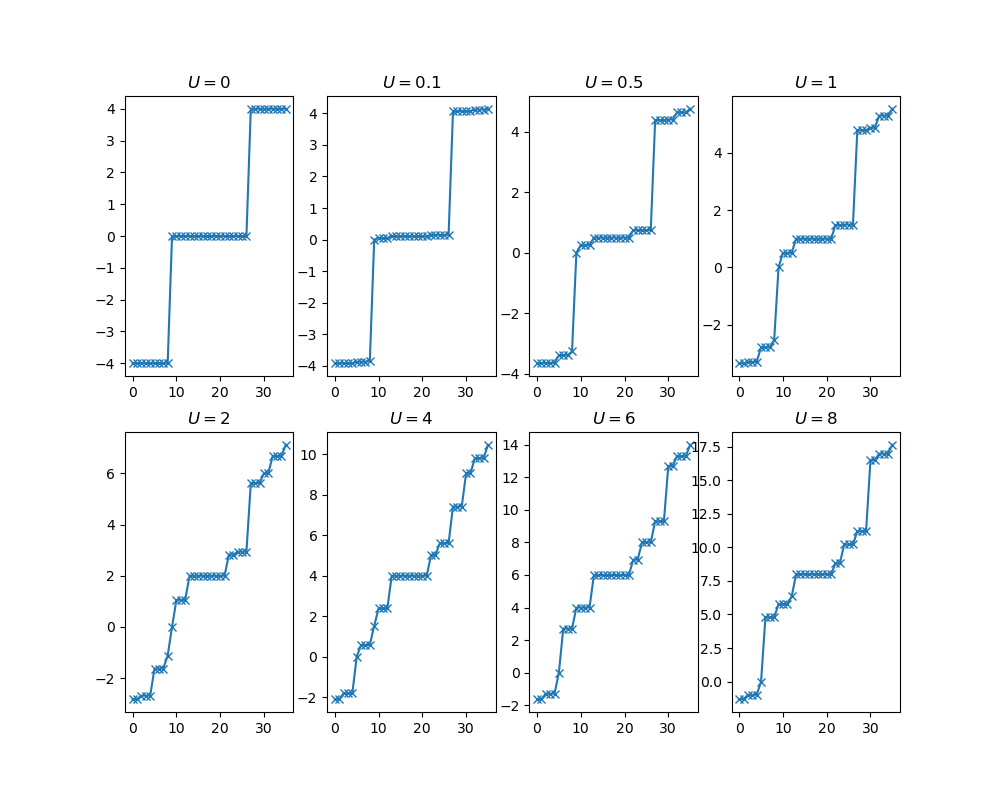

In [53]:
f,axes = plt.subplots(2,4,figsize=(10,8))

for i,u in enumerate([0,0.1,0.5,1,2,4,6,8]):
    hl = HubbardLattice1D(4, 2, 2, 1, u)
    hl.enumerate_states()
    hl.get_hamil()
    eigval,eigvec = np.linalg.eigh(hl.hamil)
    axes.flatten()[i].plot(eigval,marker='x')
    axes.flatten()[i].set_title(r'$U={u}$'.format(u=u))

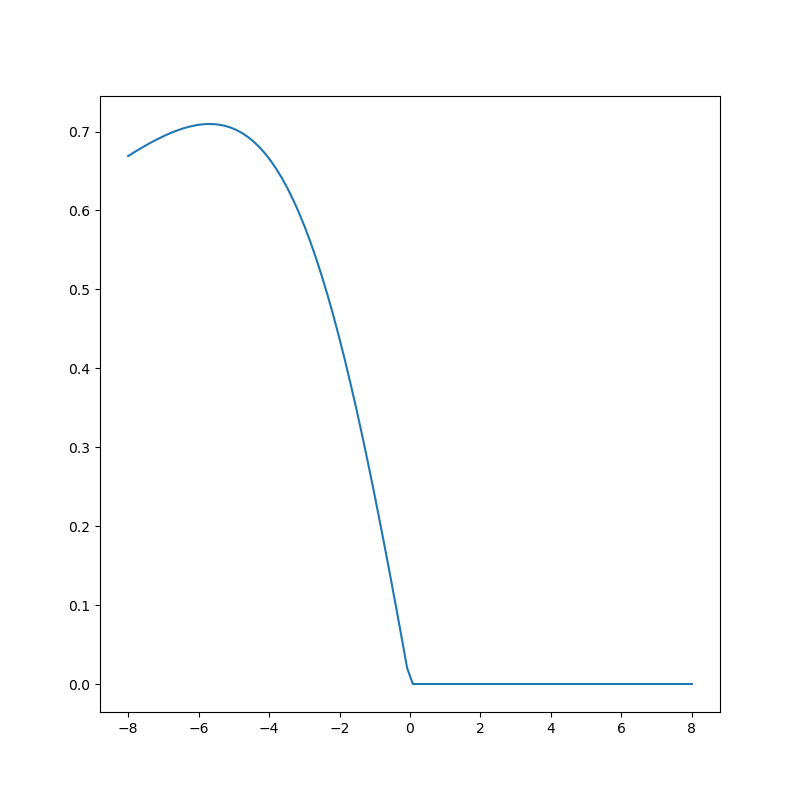

In [56]:
us = np.linspace(-8,8,100)
gap = np.zeros(len(us))

for i, u in enumerate(us):
    hl = HubbardLattice1D(4, 2, 2, 1, u)
    hl.enumerate_states()
    hl.get_hamil()
    eigval,eigvec = np.linalg.eigh(hl.hamil)
    gap[i] = eigval[1] - eigval[0]

f,ax = plt.subplots(figsize=(8,8))
ax.plot(us,gap)

## Testing ground below

In [57]:
test_bit(47,4)

0

In [47]:
annop(3,1)

(-1, 1)

In [34]:
get_excitation_level(15,51)

2

In [37]:
set_bit(15,4)

31

In [34]:
hl = HubbardLattice1D(2, 1, 0, 1, 0.5)
hl.enumerate_states()
hl.get_hamil()
print(hl.hamil)

There are 2 alpha combinations,
1 beta combinations,
making a total of 2 combinations,
requiring a memory of 0.02 kB for the list of states,
and a memory of 0.03 kB for the Hamiltonian, if requested.
[[ 0. -1.]
 [-1.  0.]]


In [32]:
np.linalg.eigh(hl.hamil)

(array([-1.,  1.]),
 array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]))

In [107]:
hl = HubbardLattice1D(4, 2, 2, 1, 1)
hl.enumerate_states()
hl.get_hamil()
np.linalg.eigh(hl.hamil)[0]

array([-3.57536562e+00, -2.59672212e+00, -1.98733842e+00, -1.70927536e+00,
       -1.47354546e+00, -1.23606798e+00, -9.78812826e-01, -9.03211926e-01,
       -7.19763745e-01, -3.24564857e-01, -4.15623061e-16, -3.78369788e-16,
       -2.07398292e-16,  3.96493220e-16,  3.46287702e-01,  8.06063434e-01,
        8.21388436e-01,  1.00000000e+00,  1.00000000e+00,  1.17861156e+00,
        1.19393657e+00,  1.65371230e+00,  2.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  2.32456486e+00,  2.71976374e+00,
        2.90321193e+00,  2.97881283e+00,  3.23606798e+00,  3.47354546e+00,
        3.70927536e+00,  3.98733842e+00,  4.59672212e+00,  5.57536562e+00])

In [104]:
hl.get_hmatel(17,20)

0.0

In [76]:
bs = [17,18,20,24,33,34,36,40,65,66,68,72,129,130,132,136]
for i,bsi in enumerate(bs):
    for j,bsj in enumerate(bs):
        print(f'{i+1}, {j+1}, {hl.get_hmatel(bsi,bsj)}')

1, 1, 1.0
1, 2, -1.0
1, 3, -1.0
1, 4, -1.0
1, 5, -1.0
1, 6, 0.0
1, 7, 0.0
1, 8, 0.0
1, 9, -1.0
1, 10, 0.0
1, 11, 0.0
1, 12, 0.0
1, 13, -1.0
1, 14, 0.0
1, 15, 0.0
1, 16, 0.0
2, 1, -1.0
2, 2, 0.0
2, 3, -1.0
2, 4, -1.0
2, 5, 0.0
2, 6, -1.0
2, 7, 0.0
2, 8, 0.0
2, 9, 0.0
2, 10, -1.0
2, 11, 0.0
2, 12, 0.0
2, 13, 0.0
2, 14, -1.0
2, 15, 0.0
2, 16, 0.0
3, 1, -1.0
3, 2, -1.0
3, 3, 0.0
3, 4, -1.0
3, 5, 0.0
3, 6, 0.0
3, 7, -1.0
3, 8, 0.0
3, 9, 0.0
3, 10, 0.0
3, 11, -1.0
3, 12, 0.0
3, 13, 0.0
3, 14, 0.0
3, 15, -1.0
3, 16, 0.0
4, 1, -1.0
4, 2, -1.0
4, 3, -1.0
4, 4, 0.0
4, 5, 0.0
4, 6, 0.0
4, 7, 0.0
4, 8, -1.0
4, 9, 0.0
4, 10, 0.0
4, 11, 0.0
4, 12, -1.0
4, 13, 0.0
4, 14, 0.0
4, 15, 0.0
4, 16, -1.0
5, 1, -1.0
5, 2, 0.0
5, 3, 0.0
5, 4, 0.0
5, 5, 0.0
5, 6, -1.0
5, 7, -1.0
5, 8, -1.0
5, 9, -1.0
5, 10, 0.0
5, 11, 0.0
5, 12, 0.0
5, 13, -1.0
5, 14, 0.0
5, 15, 0.0
5, 16, 0.0
6, 1, 0.0
6, 2, -1.0
6, 3, 0.0
6, 4, 0.0
6, 5, -1.0
6, 6, 1.0
6, 7, -1.0
6, 8, -1.0
6, 9, 0.0
6, 10, -1.0
6, 11, 0.0
6, 12, 0.0
6, 13, 

In [65]:
hl.hamil

array([[ 2., -1., -1., ...,  0.,  0.,  0.],
       [-1.,  1., -1., ...,  0.,  0.,  0.],
       [-1., -1.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1., -1.,  1.],
       [ 0.,  0.,  0., ..., -1.,  1., -1.],
       [ 0.,  0.,  0., ...,  1., -1.,  2.]])

In [39]:
occ_list_to_bit_string([0,1,2,4])

23

In [24]:
ova, ovb, ovt = bit_string_to_occ_vec(hl, 83)

In [33]:
string = pretty_print_state(hl, ova, ovb)

<IPython.core.display.Math object>

In [31]:
display(Math(string))

<IPython.core.display.Math object>

In [6]:
for i in range(4):
    for j in range(i+1):
        print(i,j)

0 0
1 0
1 1
2 0
2 1
2 2
3 0
3 1
3 2
3 3


In [31]:
comb = list(range(4))
print(comb)
ncomb = 1
while True:
    ierr,comb = next_comb(8,4,comb)
    if (ierr == 1):
        break
    print(comb)
    ncomb += 1
print(f'ncomb = {ncomb}')

[0, 1, 2, 3]
[0, 1, 2, 4]
[0, 1, 2, 5]
[0, 1, 2, 6]
[0, 1, 2, 7]
[0, 1, 3, 4]
[0, 1, 3, 5]
[0, 1, 3, 6]
[0, 1, 3, 7]
[0, 1, 4, 5]
[0, 1, 4, 6]
[0, 1, 4, 7]
[0, 1, 5, 6]
[0, 1, 5, 7]
[0, 1, 6, 7]
[0, 2, 3, 4]
[0, 2, 3, 5]
[0, 2, 3, 6]
[0, 2, 3, 7]
[0, 2, 4, 5]
[0, 2, 4, 6]
[0, 2, 4, 7]
[0, 2, 5, 6]
[0, 2, 5, 7]
[0, 2, 6, 7]
[0, 3, 4, 5]
[0, 3, 4, 6]
[0, 3, 4, 7]
[0, 3, 5, 6]
[0, 3, 5, 7]
[0, 3, 6, 7]
[0, 4, 5, 6]
[0, 4, 5, 7]
[0, 4, 6, 7]
[0, 5, 6, 7]
[1, 2, 3, 4]
[1, 2, 3, 5]
[1, 2, 3, 6]
[1, 2, 3, 7]
[1, 2, 4, 5]
[1, 2, 4, 6]
[1, 2, 4, 7]
[1, 2, 5, 6]
[1, 2, 5, 7]
[1, 2, 6, 7]
[1, 3, 4, 5]
[1, 3, 4, 6]
[1, 3, 4, 7]
[1, 3, 5, 6]
[1, 3, 5, 7]
[1, 3, 6, 7]
[1, 4, 5, 6]
[1, 4, 5, 7]
[1, 4, 6, 7]
[1, 5, 6, 7]
[2, 3, 4, 5]
[2, 3, 4, 6]
[2, 3, 4, 7]
[2, 3, 5, 6]
[2, 3, 5, 7]
[2, 3, 6, 7]
[2, 4, 5, 6]
[2, 4, 5, 7]
[2, 4, 6, 7]
[2, 5, 6, 7]
[3, 4, 5, 6]
[3, 4, 5, 7]
[3, 4, 6, 7]
[3, 5, 6, 7]
[4, 5, 6, 7]
ncomb = 70


In [28]:
next_comb(8,4,comb)

(0, [0, 1, 4, 6])